# LangChain: Evaluation

## Outline:

* Example generation
* Manual evaluation (and debuging)
* LLM-assisted evaluation

In [ ]:
#%pip install dotenv 
#%pip install pypdf
#%pip install langchain==0.0.208 
#%pip install langchain --upgrade  #Successfully installed langchain-0.1.11
%pip install -U langchain-openai 

#%pip langchain show

In [ ]:
import os

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
print(_)

## Create our QandA application

In [ ]:
from langchain.chains import RetrievalQA
#from langchain.chat_models import ChatOpenAI
from langchain_openai import ChatOpenAI
from langchain.document_loaders import CSVLoader
from langchain.indexes import VectorstoreIndexCreator
from langchain.vectorstores import DocArrayInMemorySearch

In [ ]:
file = 'OutdoorClothingCatalog_1000.csv'
loader = CSVLoader(file_path=file, encoding='utf-8')
data = loader.load()

In [ ]:
#index = VectorstoreIndexCreator(
#    vectorstore_cls=DocArrayInMemorySearch
#).from_loaders([loader])

In [ ]:
#llm = ChatOpenAI(temperature = 0.0)
#qa = RetrievalQA.from_chain_type(
#    llm=llm, 
#    chain_type="stuff", 
#    retriever=index.vectorstore.as_retriever(), 
#    verbose=True,
#    chain_type_kwargs = {
#        "document_separator": "<<<<>>>>>"
#    }
#)

In [ ]:
import openai
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
file = 'OutdoorClothingCatalog_1000.csv'
data = pd.read_csv(file, encoding='utf-8')
print(data)

#file = 'OutdoorClothingCatalog_1000.csv'
#loader = CSVLoader(file_path=file, encoding='utf-8')
#data = loader.load()

In [ ]:

import os
from openai import OpenAI

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
print(os.environ['OPENAI_API_KEY'])
openai = OpenAI(api_key=os.environ['OPENAI_API_KEY'])
#print(openai.api_key)

In [ ]:
# Assuming 'description' column contains the text to be embedded
# Generate embeddings for each document in your CSV
embeddings = []
for description in data['description']:
    response = openai.embeddings.create(
        input=description,
        model="text-embedding-ada-002"  # text-embedding-ada-002    Choose an appropriate embedding model
    )   

In [ ]:
#OLD version = embeddings.append(response['data']['embeddings'])
embeddings.append(response.data[0].embedding)

In [ ]:
print(data) 
# Store embeddings with their associated document IDs or any reference key
document_embeddings = {
    'name': data['name'],  # Assuming there's an 'name' column in your CSV
    'embeddings': embeddings
}

In [ ]:
document_embeddings

In [ ]:
# Define a function to query the embeddings with a question
def query_embeddings(question, top_k=5):
    question_embedding = openai.embeddings.create(
        input=question,
        model="text-embedding-ada-002"
    ).data[0].embedding

    # Compute similarities between question embedding and document embeddings
    similarities = cosine_similarity([question_embedding], embeddings)

    # Get top_k most similar documents
    top_k_indices = similarities.argsort()[0][-top_k:][::-1]
    top_k_documents = [data.iloc[index] for index in top_k_indices]
    
    return top_k_documents

In [ ]:
# Example query
question = "What is the best waterproof jacket?"
top_documents = query_embeddings(question)
print(top_documents)

### Coming up with test datapoints

In [ ]:
print(data.get(10))

In [ ]:
print(data.get(11))

### Hard-coded examples

In [ ]:
examples = [
    {
        "query": "Do the Cozy Comfort Pullover Set\
        have side pockets?",
        "answer": "Yes"
    },
    {
        "query": "What collection is the Ultra-Lofty \
        850 Stretch Down Hooded Jacket from?",
        "answer": "The DownTek collection"
    }
]

### LLM-Generated examples

In [ ]:
from langchain.evaluation.qa import QAGenerateChain


In [ ]:
example_gen_chain = QAGenerateChain.from_llm(ChatOpenAI())

In [ ]:
from langchain.evaluation.qa import QAGenerateChain
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate

llm = ChatOpenAI(temperature=0.9)

prompt = ChatPromptTemplate.from_template(
    "What is the best name to describe \
    a company that makes pastries?"
)

#prompt = "You are an AI trained to assist with customer service inquiries."                 
# Now you can use the QAGenerateChain class
qa_chain = QAGenerateChain(llm=llm, prompt=prompt)


new_examples = await qa_chain.aapply_and_parse(
    [{"doc": t} for t in data[:5]]
)

print(new_examples[0])

# Assuming QAGenerateChain has a method called generate_questions()
# You can call it like this
#questions = qa_chain.generate_questions("can you generate questions about cooking.")

# Then you can print or process the generated questions
#for question in questions:
#    print(question)

In [ ]:
'''
#[chain/start] [1:chain:QAGenerateChain] Entering Chain run with input:
#{
#  "input_list": [
#    {
#      "doc": "Unnamed: 0"
#    },
#    {
#      "doc": "name"
#    },
#    {
#      "doc": "description"
#    }
#  ]
#}

#[llm/start] [1:chain:QAGenerateChain > 2:llm:ChatOpenAI] Entering LLM run with input:
#{
#  "prompts": [
#    "Human: What is the best name to describe     a company that makes pastries?"
#  ]
#}

#[llm/start] [1:chain:QAGenerateChain > 3:llm:ChatOpenAI] Entering LLM run with input:
#{
#  "prompts": [
#    "Human: What is the best name to describe     a company that makes pastries?"
#  ]
#}

#[llm/start] [1:chain:QAGenerateChain > 4:llm:ChatOpenAI] Entering LLM run with input:
#{
#  "prompts": [
#    "Human: What is the best name to describe     a company that makes pastries?"
#  ]
#}

#[llm/end] [1:chain:QAGenerateChain > 2:llm:ChatOpenAI] [1.16s] Exiting LLM run with output:
#{
#  "generations": [
#    [
#      {
#        "text": "Sweet Delights Bakery",
#        "generation_info": {
#          "finish_reason": "stop",
#          "logprobs": null
#        },
#        "type": "ChatGeneration",
#        "message": {
#          "lc": 1,
#          "type": "constructor",
#          "id": [
#            "langchain",
#            "schema",
#            "messages",
#            "AIMessage"
#          ],
#          "kwargs": {
#            "content": "Sweet Delights Bakery",
#            "additional_kwargs": {}
#          }
#        }
#      }
#    ]
#  ],
#  "llm_output": {
#    "token_usage": {
#      "completion_tokens": 4,
#      "prompt_tokens": 22,
#      "total_tokens": 26
#    },
#    "model_name": "gpt-3.5-turbo",
#    "system_fingerprint": "fp_4f0b692a78"
#  },
#  "run": null  
#}


#[llm/end] [1:chain:QAGenerateChain > 3:llm:ChatOpenAI] [1.16s] Exiting LLM run with output:
#{
#  "generations": [
#    [
#      {
#        "text": "Sweet Delights Bakery",
#        "generation_info": {
#          "finish_reason": "stop",
#          "logprobs": null
#        },
#        "type": "ChatGeneration",
#        "message": {
#          "lc": 1,
#          "type": "constructor",
#          "id": [
#            "langchain",
#            "schema",
#            "messages",
#            "AIMessage"
#          ],
#          "kwargs": {
#            "content": "Sweet Delights Bakery",
#            "additional_kwargs": {}
#          }
#        }
#      }
#    ]
#  ],
#  "llm_output": {
#    "token_usage": {
#      "completion_tokens": 4,
#      "prompt_tokens": 22,
#      "total_tokens": 26
#    },
#    "model_name": "gpt-3.5-turbo",
#    "system_fingerprint": "fp_4f0b692a78"
#  },
#  "run": null  
#}


#[llm/end] [1:chain:QAGenerateChain > 4:llm:ChatOpenAI] [1.16s] Exiting LLM run with output:
#{
#  "generations": [
#    [
#      {
#...
#    "system_fingerprint": "fp_4f0b692a78"
#  },
#  "run": null
#}
'''

In [ ]:
# Assuming `example_gen_chain` is your LLMChain or similar object
# Define a parser function that processes the output from the LLMChain
def my_output_parser(raw_output):
    # Parse the raw_output according to its structure
    # This is an example; adjust the logic based on actual output structure
    parsed_output = [item('result') for item in raw_output]
    return parsed_output

In [ ]:
# Directly apply the LLMChain and parse the output with your parser function
raw_output = example_gen_chain.apply([{"doc": t} for t in data[:5]])

#parsed_output = my_output_parser(raw_output)

# Assuming there's a way to directly pass an output parser to LLMChain
#chain = LLMChain(output_parser=raw_output)

# Use the chain to process some input
#result = chain.process(input_data="Some input text")



In [ ]:
new_examples = example_gen_chain.apply_and_parse(
    [{"doc": t} for t in data[:5]]
)

In [ ]:
data[0]

In [ ]:
from langchain.chat_models import ChatOpenAI
from langchain.chains import LLMChain, TransformChain
from langchain.chains import SequentialChain


llm = ChatOpenAI(temperature=0.5)
llm_chain = LLMChain(
    prompt=prompt,
    llm=llm,
    output_key="json_string",
)

def parse_output(inputs: dict) -> dict:
    text = inputs["json_string"]
    return {"result": parser.parse(text)}

transform_chain = TransformChain(
    input_variables=["json_string"],
    output_variables=["result"],
    transform=parse_output
)

chain = SequentialChain(
    input_variables=["joke_query"],
    output_variables=["result"],
    chains=[llm_chain, transform_chain],
)

chain.run(query="Tell me a joke.")

### Combine examples

In [ ]:
examples += new_examples

In [ ]:
#qa.invoke(examples[0]["query"])

## Manual Evaluation

In [ ]:
import langchain
langchain.debug = True

In [ ]:
#qa.run(examples[0]["query"])

In [ ]:
# Turn off the debug mode
langchain.debug = False

## Create our QandA application = Michael Daigler

In [ ]:
#https://medium.com/@onkarmishra/using-langchain-for-question-answering-on-own-data-3af0a82789ed
#https://api.python.langchain.com/en/latest/langchain_api_reference.html
#https://python.langchain.com/docs/get_started/introduction

#https://python.langchain.com/docs/modules/model_io/

#https://www.youtube.com/watch?v=8qRGP2hhnSc


from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain.evaluation.qa import QAGenerateChain
#from langchain.chains import QAGenerationChain #DEPRECATED
 
#from langchain.llms import OpenAI #DEPRECATED
from langchain_openai import OpenAI

#from langchain.chat_models import ChatOpenAI #DEPRECATED
from langchain_openai import ChatOpenAI


from langchain.text_splitter import CharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
#from langchain.document_loaders import PyPDFLoader
#from langchain.vectorstores import FAISS


from dotenv import load_dotenv
load_dotenv()

import os
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

print(os.getenv("OPENAI_API_KEY"))

In [ ]:
from langchain.document_loaders import PyPDFLoader
loader = PyPDFLoader("MachineLearning-Lecture01.pdf")

#Load the document by calling loader.load()
pages = loader.load()

print(len(pages))
print(pages[0].page_content[0:500])

print(pages[0].metadata)
# {'source': 'MachineLearning-Lecture01.pdf', 'page': 0}

In [ ]:
#text_splitter = CharacterTextSplitter(chunk_size=1000,chunk_overlap=0)
#texts = text_splitter.split_documents(pages)
#print(texts)

In [ ]:
prompt = PromptTemplate(template="Question:{question}\nAnswer",input_variables=["question"])
print(prompt)

In [ ]:
#Generate Questions from examples

chain = QAGenerateChain.from_llm(ChatOpenAI(temperature=0))
qa = chain.invoke(pages[0].page_content)
qa_2 = chain.invoke(pages[1].page_content)
print(qa)

In [ ]:

#print(qa.get("qa_pairs", "Key does not exist"))

examples = [qa.get("qa_pairs", "Key does not exist"),qa_2.get("qa_pairs", "Key does not exist")]
print(examples)

#examples = []
#if 0 in qa:
#examples.append(qa[0])
#if 0 in qa_2:
#examples.append(qa_2[0])
#print(examples)

In [ ]:
#[{'query': 'According to the document, who are the TAs for the machine learning class and what are their areas of research?', 
#  'answer': 'The TAs for the machine learning class are Paul Baumstarck (machine learning and computer vision), Catie Chang (neuroscience applying machine learning to understand the human brain), Tom Do (computational biology and human learning fundamentals), Zico Kolter (machine learning applied to robots), and Daniel Ramage (learning algorithms applied to natural language processing).'}, 
# {'query': 'What are some of the departments or programs that students in the class are from, as mentioned in the document?', 
#  'answer': 'Some of the departments or programs mentioned in the document include iCME, Civi, Synthesis, Aero/astro, Chemi, MSNE, and industry.'}]


In [ ]:
'''
[chain/start][0m [1m[1:chain:QAGenerateChain] Entering Chain run with input:
[0m{
  "doc": "MachineLearning-Lecture01  \n 
   1  Instructor (Andrew Ng):  Okay. Good morning. Welcome to CS229, the machine \n
   2  learning class. So what I wanna do today is ju st spend a little time going over the logistics \n
   3  of the class, and then we'll start to  talk a bit about machine learning.  \n
   4  By way of introduction, my name's  Andrew Ng and I'll be instru ctor for this class. And so \n
   5  I personally work in machine learning, and I' ve worked on it for about 15 years now, and \n
   6  I actually think that machine learning is th e most exciting field of all the computer \n
   7  sciences. So I'm actually always excited about  teaching this class. Sometimes I actually \n
   8  think that machine learning is not only the most exciting thin g in computer science, but \n
   9  the most exciting thing in all of human endeavor, so maybe a little bias there.  \n
   10 I also want to introduce the TAs, who are all graduate students doing research in or \n
   11 related to the machine learni ng and all aspects of machin e learning. Paul Baumstarck \n
   12 works in machine learning and computer vision.  Catie Chang is actually a neuroscientist \n
   13 who applies machine learning algorithms to try to understand the human brain. Tom Do \n
   14 is another PhD student, works in computa tional biology and in sort of the basic \n
   15 fundamentals of human learning. Zico Kolter is  the head TA — he's head TA two years \n
   16 in a row now — works in machine learning a nd applies them to a bunch of robots. And \n
   17 Daniel Ramage is — I guess he's not here  — Daniel applies l earning algorithms to \n
   18 problems in natural language processing.  \n
   19 So you'll get to know the TAs and me much be tter throughout this quarter, but just from \n
   20 the sorts of things the TA's do, I hope you can  already tell that machine learning is a \n
   21 highly interdisciplinary topic in which just the TAs find l earning algorithms to problems \n
   22 in computer vision and biology and robots a nd language. And machine learning is one of \n
   23 those things that has and is having a large impact on many applications.  \n
   24 So just in my own daily work, I actually frequently end up talking to people like \n
   25 helicopter pilots to biologists to people in  computer systems or databases to economists \n
   26 and sort of also an unending stream of  people from industry coming to Stanford \n
   27 interested in applying machine learni ng methods to their own problems.  \n
   28 So yeah, this is fun. A couple of weeks ago, a student actually forwar ded to me an article \n
   29 in \"Computer World\" about the 12 IT skills th at employers can't say no to. So it's about \n
   30 sort of the 12 most desirabl e skills in all of IT and all of information technology, and \n
   31 topping the list was actually machine lear ning. So I think this is a good time to be \n
   32 learning this stuff and learning algorithms and having a large impact on many segments \n
   33 of science and industry.  \nI'm actually curious about something. Learni ng algorithms is one of the things that \n
   34 touches many areas of science and industrie s, and I'm just kind of curious. How many \n
   35 people here are computer science majors, are in the computer science department? Okay. \n
   36 About half of you. How many people are from  EE? Oh, okay, maybe about a fifth. How "
}

[[llm/start][0m [1m[1:chain:QAGenerateChain > 2:llm:ChatOpenAI] Entering LLM run with input:
[0m{
  "prompts": [
    "Human: You are a teacher coming up with questions to ask on a quiz. \n
    Given the following document, please generate a question and answer based on that document.\n\n
    Example Format:\n
    <Begin Document>\n...\n<End Document>\n
    
    QUESTION: question here\nANSWER: answer here\n\n
    
    These questions should be detailed and be based explicitly on information in the document. Begin!\n\n
    
    <Begin Document>\nMachineLearning-Lecture01  \n
    Instructor (Andrew Ng):  Okay. Good morning. Welcome to CS229, the machine \n
    learning class. So what I wanna do today is ju st spend a little time going over the logistics \n
    of the class, and then we'll start to  talk a bit about machine learning.  \n
    By way of introduction, my name's  Andrew Ng and I'll be instru ctor for this class. And so \n
    I personally work in machine learning, and I' ve worked on it for about 15 years now, and \n
    I actually think that machine learning is th e most exciting field of all the computer \n
    sciences. So I'm actually always excited about  teaching this class. Sometimes I actually \n
    think that machine learning is not only the most exciting thin g in computer science, but \n
    the most exciting thing in all of human e ndeavor, so maybe a little bias there.  \n
    I also want to introduce the TAs, who are all graduate students doing research in or \n
    related to the machine learni ng and all aspects of machin e learning. Paul Baumstarck \n
    works in machine learning and computer vision.  Catie Chang is actually a neuroscientist \n
    who applies machine learning algorithms to try to understand the human brain. Tom Do \n
    is another PhD student, works in computa tional biology and in sort of the basic \n
    fundamentals of human learning. Zico Kolter is  the head TA — he's head TA two years \n
    in a row now — works in machine learning a nd applies them to a bunch of robots. And \n
    Daniel Ramage is — I guess he's not here  — Daniel applies l earning algorithms to \n
    problems in natural language processing.  \n
    So you'll get to know the TAs and me much be tter throughout this quarter, but just from \n
    the sorts of things the TA's do, I hope you can  already tell that machine learning is a \n
    highly interdisciplinary topic in which just the TAs find l earning algorithms to problems \n
    in computer vision and biology and robots a nd language. And machine learning is one of \n
    those things that has and is having a large impact on many applications.  \n
    So just in my own daily work, I actually frequently end up talking to people like \n
    helicopter pilots to biologists to people in  computer systems or databases to economists \n
    and sort of also an unending stream of  people from industry coming to Stanford \n
    interested in applying machine learni ng methods to their own problems.  \n
    So yeah, this is fun. A couple of weeks ago, a student actually forwar ded to me an article \n
    in \"Computer World\" about the 12 IT skills th at employers can't say no to. So it's about \n
    sort of the 12 most desirabl e skills in all of IT and all of information technology, and \n
    topping the list was actually machine lear ning. So I think this is a good time to be \n
    learning this stuff and learning algorithms and having a large impact on many segments \n
    of science and industry.  \n
    I'm actually curious about something. Learning algorithms is one of the things that \n
    touches many areas of science and industrie s, and I'm just kind of curious. How many \n
    people here are computer science majors, are in the computer science department? Okay. \n
    About half of you. How many people are from  EE? Oh, okay, maybe about a fifth. How \n
    <End Document>"
  ]
}
[[llm/end][0m [1m[1:chain:QAGenerateChain > 2:llm:ChatOpenAI] [1.78s] Exiting LLM run with output:
[0m{
  "generations": [
    [
      {
        "text": "QUESTION: According to the document, who are the TAs for the machine learning class and what are their areas of research?\n
                   ANSWER: The TAs for the machine learning class are Paul Baumstarck (machine learning and computer vision), Catie Chang (neuroscience applying machine learning to understand the human brain), Tom Do (computational biology and human learning fundamentals), Zico Kolter (machine learning applied to robots), and Daniel Ramage (learning algorithms applied to natural language processing).",
        "generation_info": {
          "finish_reason": "stop",  ---> COMPLETED OK
          "logprobs": null
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "QUESTION: According to the document, who are the TAs for the machine learning class and what are their areas of research?\nANSWER: The TAs for the machine learning class are Paul Baumstarck (machine learning and computer vision), Catie Chang (neuroscience applying machine learning to understand the human brain), Tom Do (computational biology and human learning fundamentals), Zico Kolter (machine learning applied to robots), and Daniel Ramage (learning algorithms applied to natural language processing).",
            "additional_kwargs": {}
          }
        }
      }
    ]
  ],
  "llm_output": {
    "token_usage": {
      "completion_tokens": 99,
      "prompt_tokens": 795,
      "total_tokens": 894
    },
    "model_name": "gpt-3.5-turbo",
    "system_fingerprint": "fp_2b778c6b35"
  },
  "run": null
}

[[chain/end][0m [1m[1:chain:QAGenerateChain] [1.78s] Exiting Chain run with output:
[0m{
  "qa_pairs": {
    "query": "According to the document, who are the TAs for the machine learning class and what are their areas of research?",
    "answer": "The TAs for the machine learning class are Paul Baumstarck (machine learning and computer vision), Catie Chang (neuroscience applying machine learning to understand the human brain), Tom Do (computational biology and human learning fundamentals), Zico Kolter (machine learning applied to robots), and Daniel Ramage (learning algorithms applied to natural language processing)."
  }
}

[[chain/start][0m [1m[1:chain:QAGenerateChain] Entering Chain run with input:
[0m{
  "doc": "many biologers are there here? Wow, just a few, not many. I'm surprised. Anyone from \nstatistics? Okay, a few. So where are the rest of you from?  \nStudent : iCME.  \nInstructor (Andrew Ng) : Say again?  \nStudent : iCME.  \nInstructor (Andrew Ng) : iCME. Cool.  \nStudent : [Inaudible].  \nInstructor (Andrew Ng) : Civi and what else?  \nStudent : [Inaudible]  \nInstructor (Andrew Ng) : Synthesis, [inaudible] systems. Yeah, cool.  \nStudent : Chemi.  \nInstructor (Andrew Ng) : Chemi. Cool.  \nStudent : [Inaudible].  \nInstructor (Andrew Ng) : Aero/astro. Yes, right. Yeah, okay, cool. Anyone else?  \nStudent : [Inaudible].  \nInstructor (Andrew Ng) : Pardon? MSNE. All ri ght. Cool. Yeah.  \nStudent : [Inaudible].  \nInstructor (Andrew Ng) : Pardon?  \nStudent : [Inaudible].  \nInstructor (Andrew Ng) : Endo —  \nStudent : [Inaudible].  \nInstructor (Andrew Ng) : Oh, I see, industry. Okay. Cool. Great, great. So as you can \ntell from a cross-section of th is class, I think we're a very diverse audience in this room, \nand that's one of the things that makes this class fun to teach and fun to be in, I think.  "
}

[[llm/start][0m [1m[1:chain:QAGenerateChain > 2:llm:ChatOpenAI] Entering LLM run with input:
[0m{
  "prompts": [
    "Human: You are a teacher coming up with questions to ask on a quiz. \nGiven the following document, please generate a question and answer based on that document.\n\nExample Format:\n<Begin Document>\n...\n<End Document>\nQUESTION: question here\nANSWER: answer here\n\nThese questions should be detailed and be based explicitly on information in the document. Begin!\n\n<Begin Document>\nmany biologers are there here? Wow, just a few, not many. I'm surprised. Anyone from \nstatistics? Okay, a few. So where are the rest of you from?  \nStudent : iCME.  \nInstructor (Andrew Ng) : Say again?  \nStudent : iCME.  \nInstructor (Andrew Ng) : iCME. Cool.  \nStudent : [Inaudible].  \nInstructor (Andrew Ng) : Civi and what else?  \nStudent : [Inaudible]  \nInstructor (Andrew Ng) : Synthesis, [inaudible] systems. Yeah, cool.  \nStudent : Chemi.  \nInstructor (Andrew Ng) : Chemi. Cool.  \nStudent : [Inaudible].  \nInstructor (Andrew Ng) : Aero/astro. Yes, right. Yeah, okay, cool. Anyone else?  \nStudent : [Inaudible].  \nInstructor (Andrew Ng) : Pardon? MSNE. All ri ght. Cool. Yeah.  \nStudent : [Inaudible].  \nInstructor (Andrew Ng) : Pardon?  \nStudent : [Inaudible].  \nInstructor (Andrew Ng) : Endo —  \nStudent : [Inaudible].  \nInstructor (Andrew Ng) : Oh, I see, industry. Okay. Cool. Great, great. So as you can \ntell from a cross-section of th is class, I think we're a very diverse audience in this room, \nand that's one of the things that makes this class fun to teach and fun to be in, I think.  \n<End Document>"
  ]
}

[[llm/end][0m [1m[1:chain:QAGenerateChain > 2:llm:ChatOpenAI] [1.58s] Exiting LLM run with output:
[0m{
  "generations": [
    [
      {
        "text": "QUESTION: What are some of the departments or programs that students in the class are from, according to the document?\n\nANSWER: Some of the departments or programs that students in the class are from include iCME, Civi, Synthesis, Aero/astro, Chemi, MSNE, and industry.",
        "generation_info": {
          "finish_reason": "stop",
          "logprobs": null
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "QUESTION: What are some of the departments or programs that students in the class are from, according to the document?\n\nANSWER: Some of the departments or programs that students in the class are from include iCME, Civi, Synthesis, Aero/astro, Chemi, MSNE, and industry.",
            "additional_kwargs": {}
          }
        }
      }
    ]
  ],

  "llm_output": {
    "token_usage": {
      "completion_tokens": 63,
      "prompt_tokens": 421,
      "total_tokens": 484
    },
    "model_name": "gpt-3.5-turbo",
    "system_fingerprint": "fp_4f0b692a78"
  },
  "run": null
}
[[chain/end][0m [1m[1:chain:QAGenerateChain] [1.58s] Exiting Chain run with output:
[0m{
  "qa_pairs": {
    "query": "What are some of the departments or programs that students in the class are from, according to the document?",
    "answer": "Some of the departments or programs that students in the class are from include iCME, Civi, Synthesis, Aero/astro, Chemi, MSNE, and industry."
  }
}
[]
'''

In [ ]:

actual_question ="who are the TAs for the machine learning class?"

review_prompt = """\
Question: {question}\n

Answer:
"""

prompt_template = ChatPromptTemplate.from_template(review_prompt)
print(prompt_template)


result_prompt = prompt_template.format_messages(question=actual_question)
print(result_prompt[0].content)
print(result_prompt)

# Assuming result_prompt is a tuple of key-value pairs
result_prompt = (("key1", result_prompt[0].content), ("key2", result_prompt[0].content))
prompt_dict = dict(result_prompt)
print(prompt_dict)


In [57]:
#https://platform.openai.com/docs/deprecations

prompt = PromptTemplate(template="Query: {query}\nAnswer",input_variables=["query"])
print(prompt)

llm = OpenAI(model="gpt-3.5-turbo-instruct", temperature=0.7) #gpt-4-1106-preview;  DEPRECATED= text-davinci-003
#chain = LLMChain(llm=llm, prompt=prompt_dict)

chain = LLMChain(llm=llm, prompt=prompt)
print(chain)

input_variables=['query'] template='Query: {query}\nAnswer'
prompt=PromptTemplate(input_variables=['query'], template='Query: {query}\nAnswer') llm=OpenAI(client=<openai.resources.completions.Completions object at 0x0000021ABFD02190>, async_client=<openai.resources.completions.AsyncCompletions object at 0x0000021ABFF3C1D0>, openai_api_key=SecretStr('**********'), openai_proxy='')


In [58]:

examples = [
    {
        "query": "Does 1 + 1 equals 2?",
        "answer": "Yes"
    },
    {
        "query": "Does 2 + 2 equals 5?",
        "answer": "No"
    }
]


In [59]:
print(examples)

[{'query': 'Does 1 + 1 equals 2?', 'answer': 'Yes'}, {'query': 'Does 2 + 2 equals 5?', 'answer': 'No'}]


In [60]:
#Make predictions

predictions = chain.apply(examples)
print([predictions])

[[{'text': ': Yes, 1 + 1 does equal 2. This is a basic principle of mathematics and is known as the commutative property of addition. When adding two numbers together, the result will always be the sum of the two numbers. In this case, 1 + 1 is equal to 2 because 1 + 1 = 2.'}, {'text': ': No, 2 + 2 equals 4.'}]]


In [ ]:
'''
[[{'text': ': No, the Cozy Comfort Pullover Set does not have side pockets.'}, 
  {'text': ': The Ultra-Lofty 850 Stretch Down Hooded Jacket is from The North Face collection.'}]]
'''

## LLM Assisted Evaluation

In [61]:
#Make Evaluation
from langchain.evaluation.qa import QAEvalChain

llm = OpenAI(temperature=0.7)
eval_chain = QAEvalChain.from_llm(llm)

#graded_outputs = eval_chain.evaluate(examples, predictions, question_key="question",prediction_key="text")

graded_outputs = eval_chain.evaluate(examples, predictions, question_key="query", answer_key="answer", prediction_key="text")

In [62]:
print(graded_outputs)

[{'results': ' CORRECT'}, {'results': ' CORRECT'}]


In [63]:
for i, example in enumerate(examples):
    print(f"Example {i}:")
    print("Question: " + example['query'])  #CHECK if you are using query or question
    print("Answer: " + example['answer'])
    print("Predicted Answer: " + predictions[i]['text'])
    print("Predicted Grade: " + graded_outputs[i]['results'])
    print()

Example 0:
Question: Does 1 + 1 equals 2?
Answer: Yes
Predicted Answer: : Yes, 1 + 1 does equal 2. This is a basic principle of mathematics and is known as the commutative property of addition. When adding two numbers together, the result will always be the sum of the two numbers. In this case, 1 + 1 is equal to 2 because 1 + 1 = 2.
Predicted Grade:  CORRECT

Example 1:
Question: Does 2 + 2 equals 5?
Answer: No
Predicted Answer: : No, 2 + 2 equals 4.
Predicted Grade:  CORRECT



## Ways to reduce general hallucinations
### Prompt Engineering Techniques
###### Request for evidence === According to the provided documents, Refer to the docs, Quote the original doc
###### Set Boundaries === The only verified docs between START VERIFIED DOCS and END VERIFIED DOCS = Answer solely on the docs provided
###### Step by Step Reasoning === Lets think step by step about how to solve this question, here are the provided docs that might help you. Say I don't know if you are unable to answer based on the docs provided...
###### Describe first in detail === Describe first in detail before attempting to answer

### Improve your information retrieval (IR) system
###### if the retriever grabs irrelevant docs or if the documents are not split accordingly, the completion will hallucinate most of the time.
##### Invest in good information retrieval evaluation
##### Larger text splitting vs smaller ones depending on the use case {maintain context vs efficiency} TRADEOFF?
##### Hybrid Search. A mixture between semantic and keyword search

## Ways to prevent incorrect results

##### detect when information retrieval returns 0 docs
###### raises a flag, indicating the model needs to come up with an answer through its training set and not through docs provided
###### decrease the confidence level and let the user know 
###### delegate to customers to decide if we want the model to be "creative" and try to answer or not.
##### teach the model functionality
###### Let the users revise incorrect answers = then re-index this into the vector database with a determined proximity

## Evaluating Hallucinations

###### Evaluate each step of your process separately
###### Have an IR evaluation ; have completion evaluations;
###### Invest time in create a great evaluation data-set
###### OPENAI Evals and Langchain Auto Evaluator
###### Adversarial testing:  I dont know is better than an incorrect answer

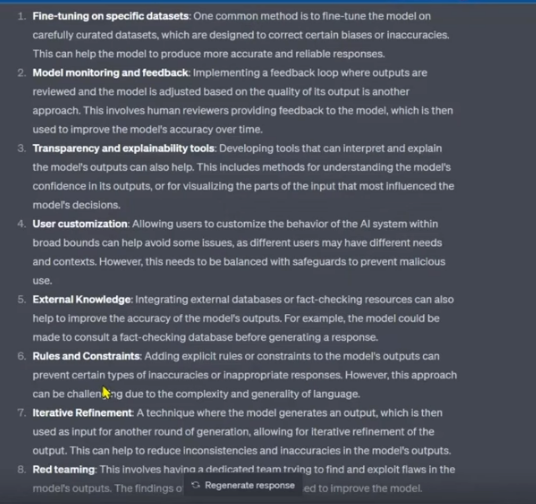

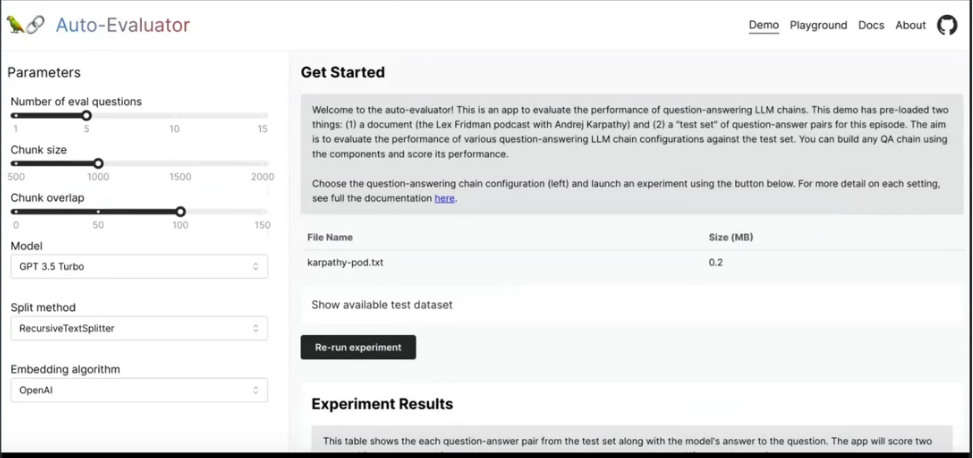

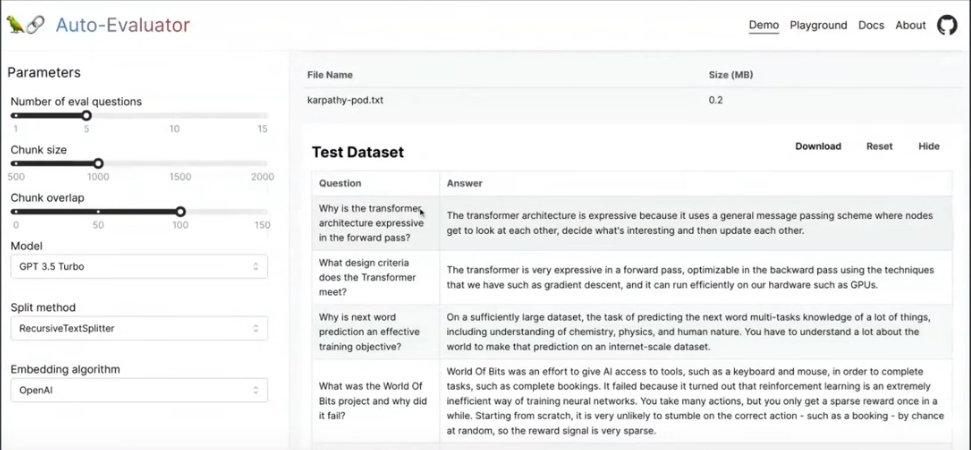

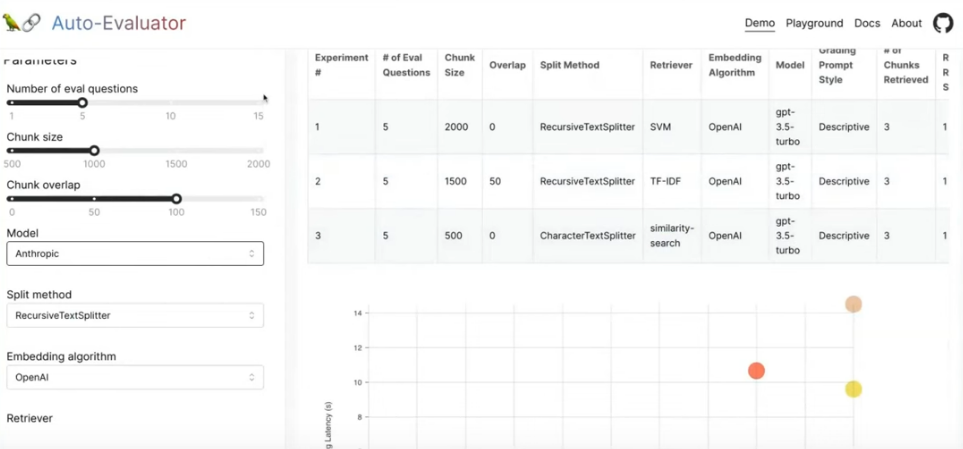

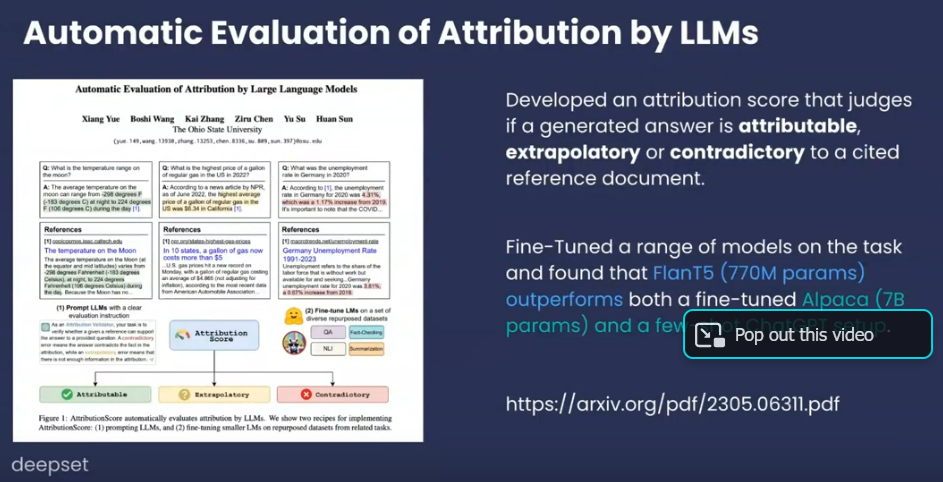

https://youtu.be/QDsE6vYA82A?si=oYnaQPLyCHfB4qY0